In [9]:
import geopandas as gpd
import numpy as np
import pandas as pd

default_crs = '32718'

# Calculating heatmap

### Define input variables
gdf : land_uses data

unit : spatial area to group (grid/hex/block)

In [15]:
select_unit = 'hex'
# scenario = 'actual'
scenario = 'future'

In [16]:
# Load input data
gdf = gpd.read_file(f'/app/assets/land_uses/{scenario}')
unit = gpd.read_file(f'/app/assets/groupby/{select_unit}')

In [17]:
# Preprocess land_uses
gdf['Uso'] = gdf['Uso'].fillna('NO INFORMADO')
mask = gdf['Uso'].isin(['NO INFORMADO', 'SIN INFORMACIÓN'])
gdf.loc[mask, 'Uso'] = 'OTROS'
gdf['area_predio'] = gdf.area

In [24]:
gdf.to_parquet(f'/app/assets/land_uses/{scenario}.parquet')

In [22]:
gdf = gpd.read_parquet(f'/app/assets/land_uses/actual.parquet')

In [23]:
gdf.head(3)

,Rol,Avaluo,Uso,geometry,area_predio
0,1392-2,1.091677e+09,SITIO ERIAZO,"POLYGON ((671840.723 5922742.217, 671776.826 5...",27346.338208
1,95000-17,3.038130e+08,SITIO ERIAZO,"POLYGON ((672354.137 5923064.083, 672358.106 5...",10492.917473
2,1380-90001,4.516303e+08,BIENES COMUNES,"POLYGON ((671968.972 5922686.292, 671968.972 5...",2466.607737


In [13]:
# Preprocess unit
unit['area_unit'] = unit.area

##### Start processing data

In [6]:
# Intersection between land_uses and units
intersection = gpd.sjoin(unit, gdf, how="inner", op="intersects")
intersection['area'] = intersection.area

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [7]:
# Filter intersection geodataframe by columns
inter_cols = [f'{select_unit}_id', 'Uso', 'area', 'area_unit', 'area_predio']
intersection = intersection[inter_cols]

total_inter_area = intersection.groupby([f'{select_unit}_id'])['area'].agg('sum').reset_index().rename(columns={'area': 'inter_area'})
intersection = pd.merge(intersection, total_inter_area, on=f'{select_unit}_id')
intersection['property_percentage'] = intersection['area']/intersection['inter_area']
intersection['information_per_property'] = -1*intersection['property_percentage']*np.log(intersection['property_percentage'])
diversity = intersection.groupby(f'{select_unit}_id')['information_per_property'].agg('sum').reset_index()
diversity_map = pd.merge(diversity, unit, on=f'{select_unit}_id')
diversity_map.rename(columns={'information_per_property': 'diversity'}, inplace=True)
diversity_map = gpd.GeoDataFrame(data=diversity_map['diversity'], geometry=diversity_map['geometry'])
diversity_map.to_file(f'/app/data/diversity_map_{scenario}_{select_unit}')

0.0009459022283520968


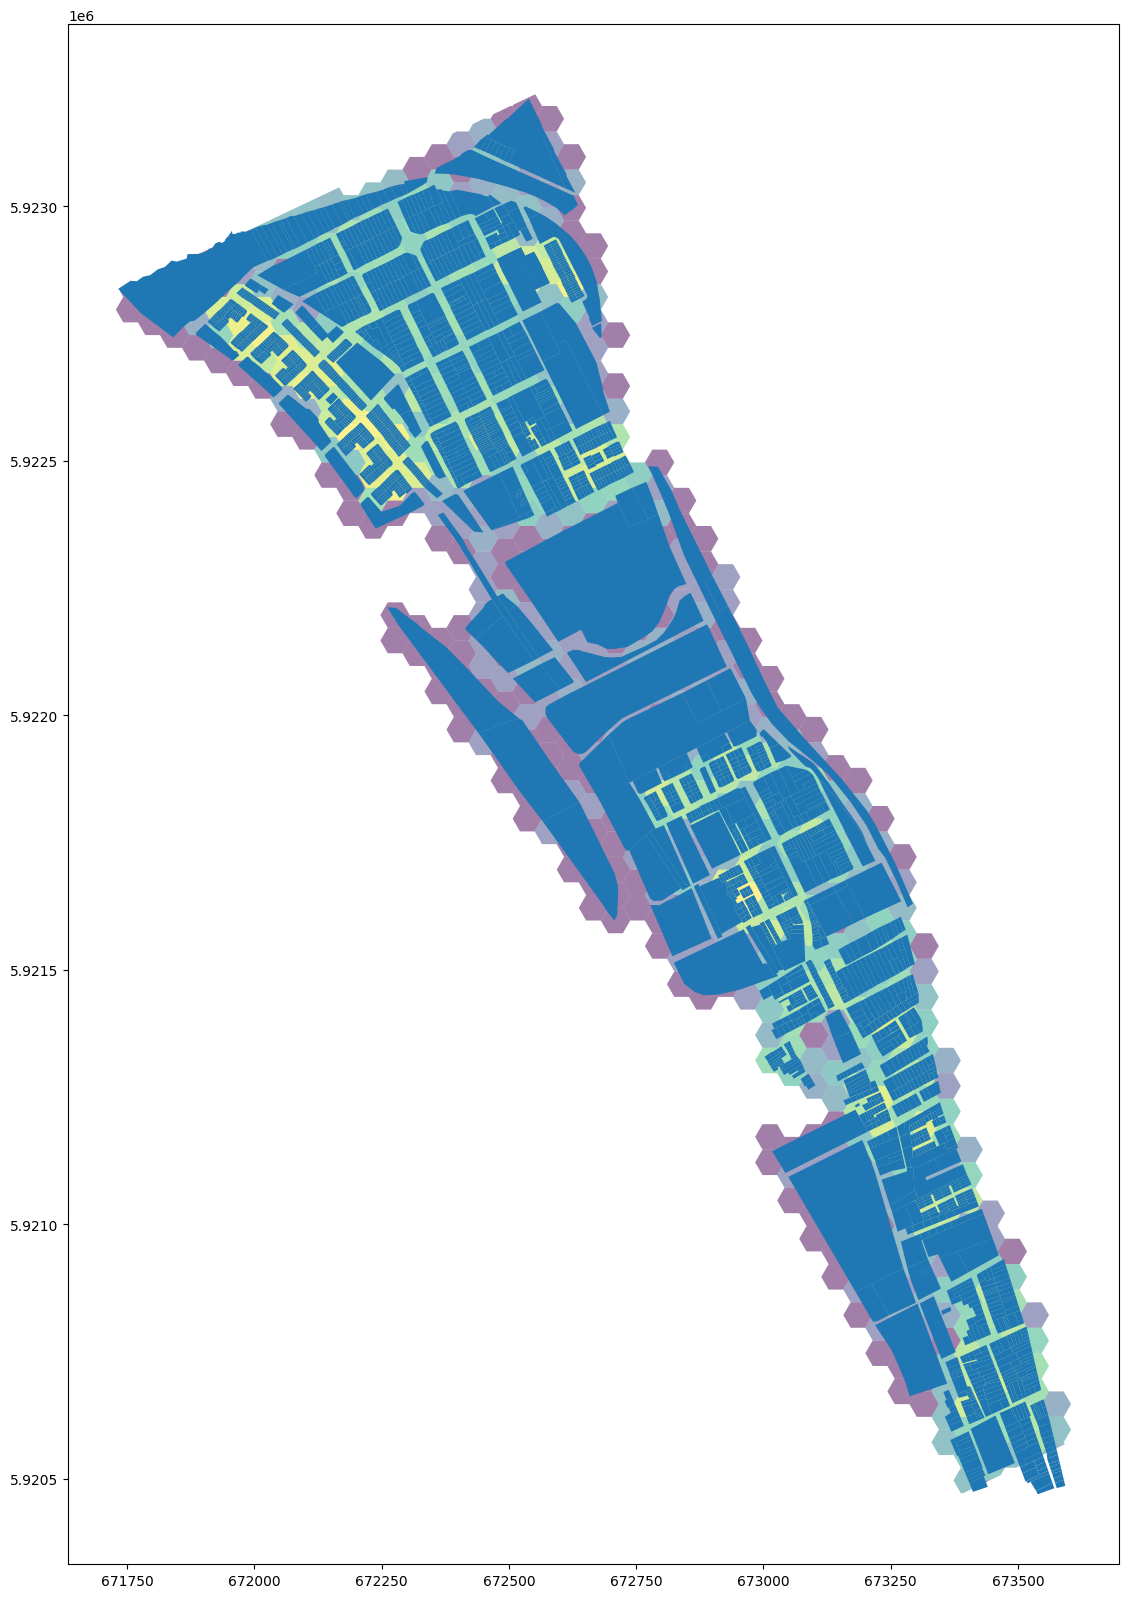

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
diversity_map.plot(column='diversity', ax=ax, alpha=0.5)
gdf.plot(ax=ax)
total_hect = gdf['area_predio'].sum()
diversity_indicator = diversity_map['diversity'].sum()/total_hect
print(diversity_indicator)

In [1]:
# diversity_map.plot(column='diversity', figsize=(20,20))
# total_hect = gdf['area_predio'].sum()
# diversity_indicator = diversity_map['diversity'].sum()/total_hect
# print(diversity_indicator)

# Identify actual and future land_uses in plates

In [43]:
land_uses_cols = ['Uso', 'geometry']
future_land_uses = gpd.read_file('/app/assets/land_uses/future')[land_uses_cols]
actual_land_uses = gpd.read_file('/app/assets/land_uses/actual')[land_uses_cols]

In [27]:
n_plate = '3'
plate = gpd.read_file(f'/app/assets/plates/{n_plate}').to_crs(default_crs)

In [28]:
actual_lands_to_change = gpd.sjoin(actual_land_uses, plate, how='inner')
future_lands_to_change = gpd.sjoin(future_land_uses, plate, how='inner')

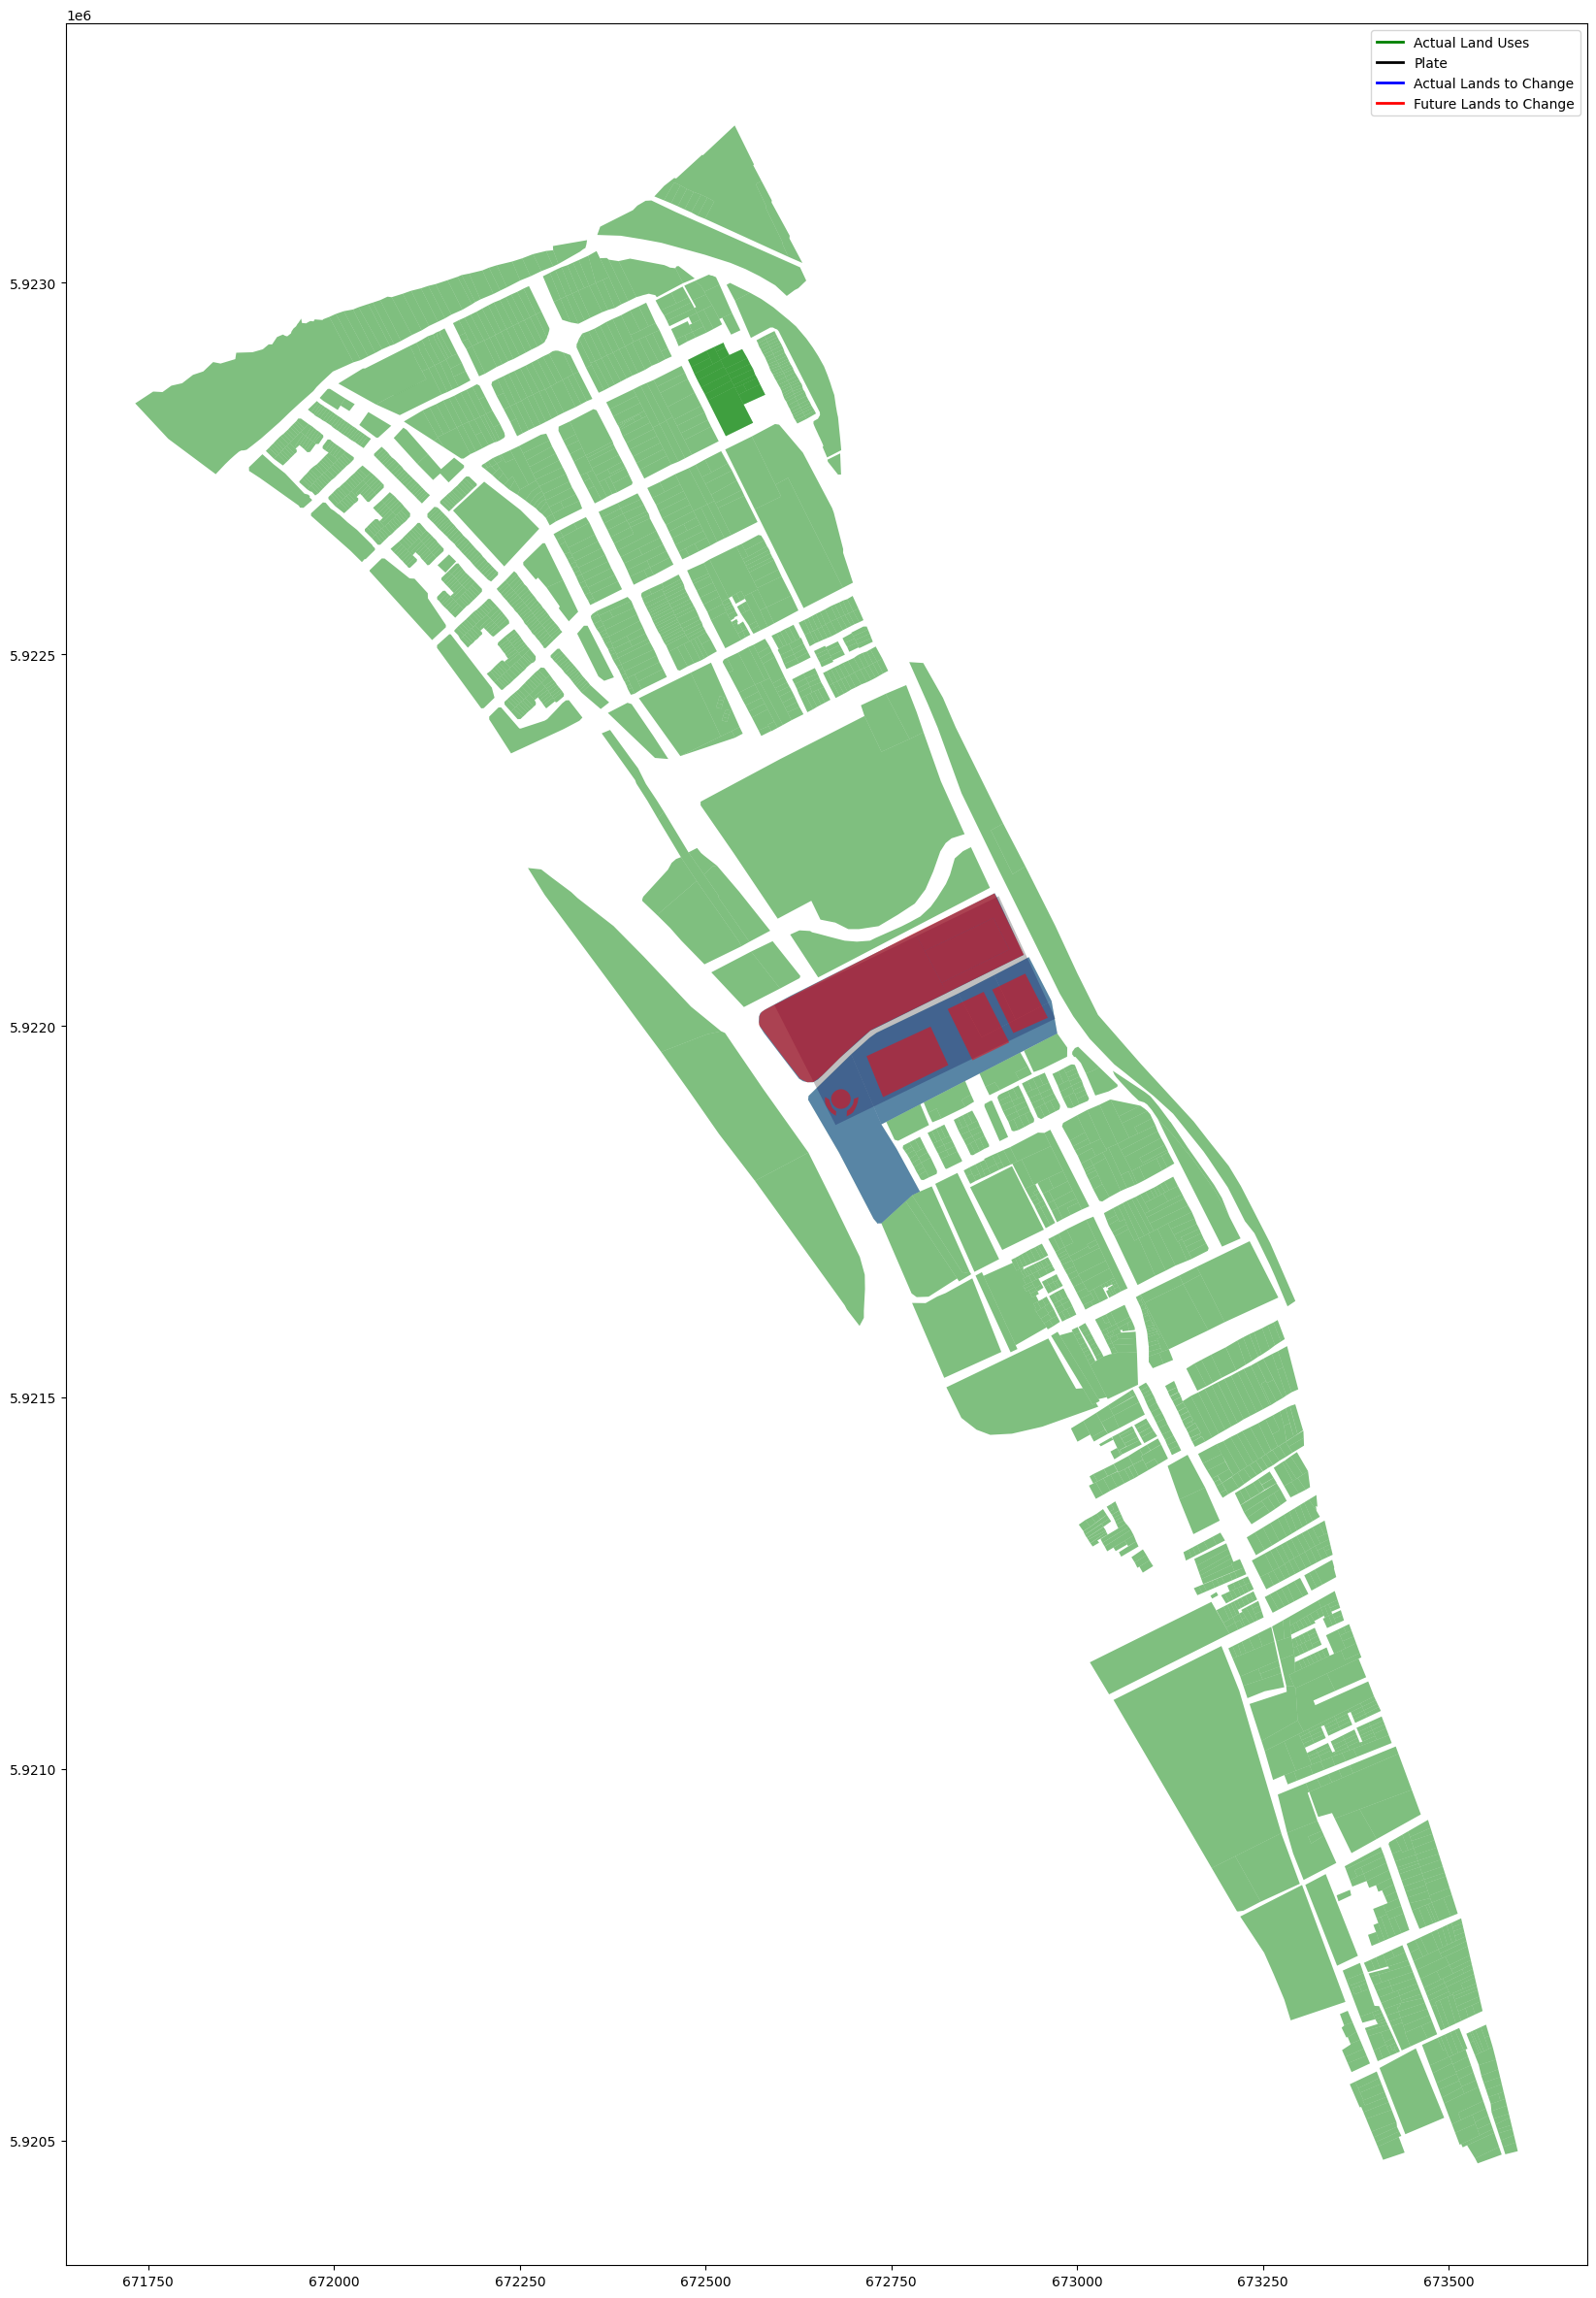

In [39]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(30, 30))

# Dibujar el objeto actual_land_uses con un nuevo color
actual_land_uses_plot = actual_land_uses.plot(ax=ax, color='green', alpha=0.5, label='Actual Land Uses')

# Dibujar los gráficos
plate_plot = plate.plot(ax=ax, color='black', alpha=0.25)
actual_lands_plot = actual_lands_to_change.plot(ax=ax, color='blue', alpha=0.3)
future_lands_plot = future_lands_to_change.plot(ax=ax, color='red', alpha=0.5)

# Crear objetos Line2D con etiquetas
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Actual Land Uses'),
    Line2D([0], [0], color='black', lw=2, label='Plate'),
    Line2D([0], [0], color='blue', lw=2, label='Actual Lands to Change'),
    Line2D([0], [0], color='red', lw=2, label='Future Lands to Change'),
]

# Agregar la leyenda
ax.legend(handles=legend_elements, loc='upper right')

# Mostrar el gráfico
plt.show()


/tmp/ipykernel_12/3144387306.py:6: UserWarning: `keep_geom_type=True` in overlay resulted in 6194 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection = gpd.overlay(actual_land_uses, future_land_uses, how='intersection')
/tmp/ipykernel_12/3144387306.py:9: UserWarning: The indices of the two GeoSeries are different.
  elements_not_in_intersection = future_land_uses.difference(intersection)


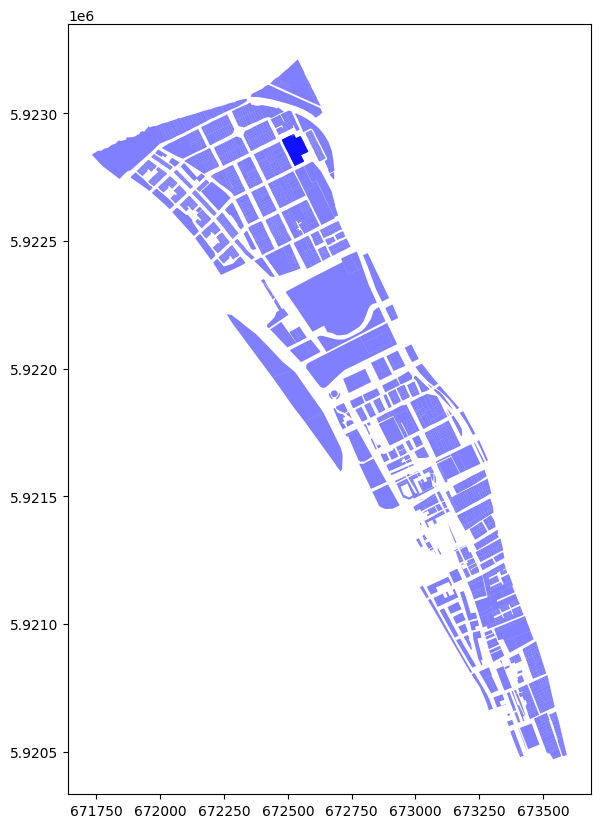

In [47]:
# Corregir geometrías para eliminar intersecciones internas
actual_land_uses['geometry'] = actual_land_uses['geometry'].buffer(0)
future_land_uses['geometry'] = future_land_uses['geometry'].buffer(0)

# Realizar una operación de intersección
intersection = gpd.overlay(actual_land_uses, future_land_uses, how='intersection')

# Encontrar los elementos que no están en la intersección
elements_not_in_intersection = future_land_uses.difference(intersection)

# Crear una figura y ejes para el gráfico
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear los elementos no incluidos en la intersección en un color diferente
# elements_not_in_intersection.plot(ax=ax, color='green', edgecolor='black')

# Plotear la intersección en otro color si es necesario
intersection.plot(ax=ax, color='blue', alpha=0.5)

# Puedes ajustar la apariencia y agregar más elementos según tus necesidades

# Mostrar el gráfico
plt.show()
